In [2]:
import earthnet_minicuber as emc
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import datetime
import xarray as xr
import rioxarray as rioxr

In [48]:
# Hide warnings (many since some xarray class uses some deprecated python function on 3.9)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import xarray as xr
import numpy as np
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def ssim_wrapper(img1, img2):
    return ssim(img1, img2, data_range=2.0)

#takes in a single prediction minicube pair (file names) to calculate metrics on a single prediction
#outputs a dictionary whose entries are xarrays of a single metric with 20 values (one for each prediction timestep)
def calculate_metrics(input_nc, reference_nc):
    cloud_threshold = 0.2
    input_ndvi = xr.open_dataset(input_nc)["ndvi_pred"]
    reference = xr.open_dataset(reference_nc)
    reference_B4 = reference["s2_B04"]
    dates = reference.time.values
    
    #finding the first date with an S2 image and determining the image offset
    for i in range(len(dates)): 
        if not reference_B4.sel(time=dates[i]).isnull().all().item():
            offset = i%5
            break

    #dropping non S2 imagery dates 
    for i in range(dates.size):
        if i < offset:
            reference = reference.drop_sel(time=dates[i])
        else:
            offset += 5
            if offset <55:
                reference = reference.drop_sel(time=dates[i])   

    #ndvi calculation
    reference["ndvi"] = (("time", "x", "y"), np.zeros((20, 128, 128)))
    reference["ndvi"] = (reference["s2_B8A"] - reference["s2_B04"]) / xr.where((reference["s2_B8A"] + reference["s2_B04"]) == 0, np.nan, (reference["s2_B8A"] + reference["s2_B04"]))
    
    #masking cloudy pixels with NaNs which are handled by numpy and xarray methods
    masked = reference.where(reference["s2_dlmask"] == 0)
    reference_ndvi = masked["ndvi"]
    #NaNs are not handled by skimage, so clouds are masked with the average NDVI value of the timestep
    ssim_reference_ndvi = reference_ndvi.fillna(reference_ndvi.mean(dim=("lat", "lon"), skipna=True))

    residuals = input_ndvi - reference_ndvi
    
    #metrics calculations
    U = np.sqrt((residuals**2).mean(dim=("lat", "lon"))) #RMSE
    A = (residuals).mean(dim=("lat", "lon"))
    P = np.sqrt(((residuals - A)**2).mean(dim=("lat", "lon")))
    R = xr.corr(input_ndvi, reference_ndvi, dim=("lat", "lon"))
    SSIM = xr.apply_ufunc(
        ssim_wrapper,
        input_ndvi,
        ssim_reference_ndvi,
        input_core_dims=[["lat","lon"], ["lat","lon"]],
        vectorize=True,
        output_dtypes=[float]
    )

    #dropping metrics for dates that are too cloudy
    cloud = (reference["s2_dlmask"] == 0).sum(dim=["lat", "lon"]) < (128*128*(1-cloud_threshold))
    for i in range(20):
        if cloud[i].item():
            U[i] = np.nan
            A[i] = np.nan
            P[i] = np.nan
            R[i] = np.nan
            SSIM[i] = np.nan

    return {
        "Uncertainty": U,
        "Accuracy": A,
        "Precision": P,
        "Pearson Correlation": R,
        "SSIM": SSIM
    }

#takes in an array of prediction file names and an array of corresponding minicube file names to calculate metrics on multiple predictions
#outputs a dictionary where each entry contains a collection of xarrays; each xarray corresponds to the given metric of a single prediction
def gather_metrics(input_files, reference_files):
    U = []
    A = []
    P = []
    R = []
    SSIM = []
    for i in range(len(input_files)):
        metrics = calculate_metrics(input_files[i], reference_files[i])
        U.append(metrics["Uncertainty"])
        A.append(metrics["Accuracy"])
        P.append(metrics["Precision"])
        R.append(metrics["Pearson Correlation"])
        SSIM.append(metrics["SSIM"])
    return {
        "Uncertainty": U,
        "Accuracy": A,
        "Precision": P,
        "Pearson Correlation": R,
        "SSIM": SSIM
    }

#expects each dataset to be an array of xarrays
def plot_metric(crop_datasets, forest_datasets, shrub_datasets, metric):
    datasets = [crop_datasets, forest_datasets, shrub_datasets]
    
    #converting xarrays to pandas dataframes, replacing the time dimension's datetimes with intergers corresponding to the timestpe
    #and adding a landcover-type variable
    for l in range(3):
        for i in range(len(datasets[l])):
            datasets[l][i] = datasets[l][i].assign_coords(time=np.arange(1, datasets[l][i].sizes["time"] + 1)).to_dataframe(name=metric).reset_index().assign(land_type=["Crop", "Forest", "Shrub"][l])

    #merging each prediction's dataframe into a single dataframe for the entire landcover-type 
    crop_data = pd.concat(datasets[0], ignore_index=True)
    forest_data = pd.concat(datasets[1], ignore_index=True)
    shrub_data = pd.concat(datasets[2], ignore_index=True)

    #merging all the data into a single dataframe to be plotted
    all_data = pd.concat([crop_data, forest_data, shrub_data], ignore_index=True)
    sns.boxplot(
        data=all_data,
        x="time",
        y=metric,
        hue="land_type"
    )

#returns arrays of prediction files, with the predictions argument specifying whether these are original or retrained predictions
#the three arrays returned correspond to each of the 3 landcover types
def gather_inputs(root, predictions, sites):
    collection = []
    for landcover in sites:
        landcover_sites = []
        for tile in sites[landcover]:
            dir = f"{root}/{landcover}/{tile}/{predictions}/MJJ21"
            for file in os.listdir(dir):
                if file.endswith(".nc"):
                    landcover_sites.append(os.path.join(dir, file))
        collection.append(landcover_sites)
    return collection[0], collection[1], collection[2]

#returns arrays of minicubes files
#the three arrays returned correspond to each of the 3 landcover types
def gather_references(root, sites):
    collection = []
    for landcover in sites:
        landcover_sites = []
        for tile in sites[landcover]:
            dir = f"{root}/{landcover}/{tile}/ood-t_chopped/MJJ21"
            for file in os.listdir(dir):
                if file.endswith(".nc") and not file.endswith(("NE.nc", "NW.nc", "SE.nc", "SW.nc")):
                    landcover_sites.append(os.path.join(dir, file))
        collection.append(landcover_sites)
    return collection[0], collection[1], collection[2]

#returns arrays of blocking treatment related prediction files
#prediction_type = "offset" specifies returniing the averaged prediction, any other value will return the center ("original") prediction
#the three arrays returned correspond to each of the 3 landcover types
def gather_offset_inputs(root, prediction_type, sites):
    collection = []
    for landcover in sites:
        landcover_sites = []
        for tile in sites[landcover]:
            dir = f"{root}/{landcover}/{tile}/predictions/MJJ21"
            for file in os.listdir(dir):
                if prediction_type == "offset":
                    if file.endswith("average.nc"):
                        landcover_sites.append(os.path.join(dir, file))
                else:
                    if file.endswith(".nc") and not file.endswith(("NE.nc", "NW.nc", "SE.nc", "SW.nc", "average.nc")):
                        landcover_sites.append(os.path.join(dir, file))
                        
        collection.append(landcover_sites)
    return collection[0], collection[1], collection[2]

Retrained

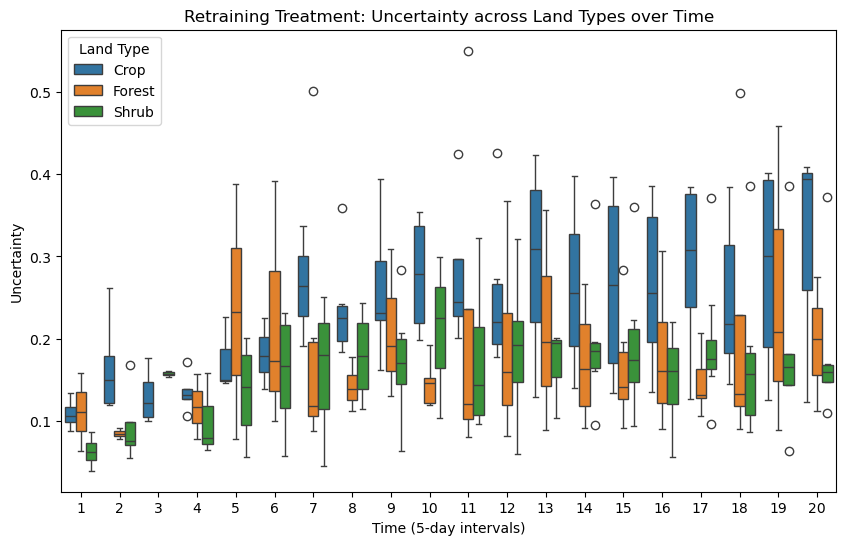

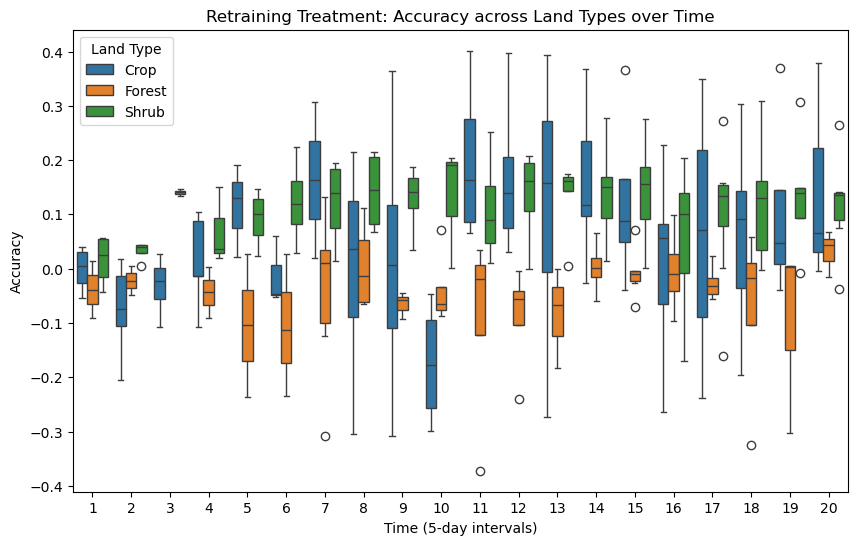

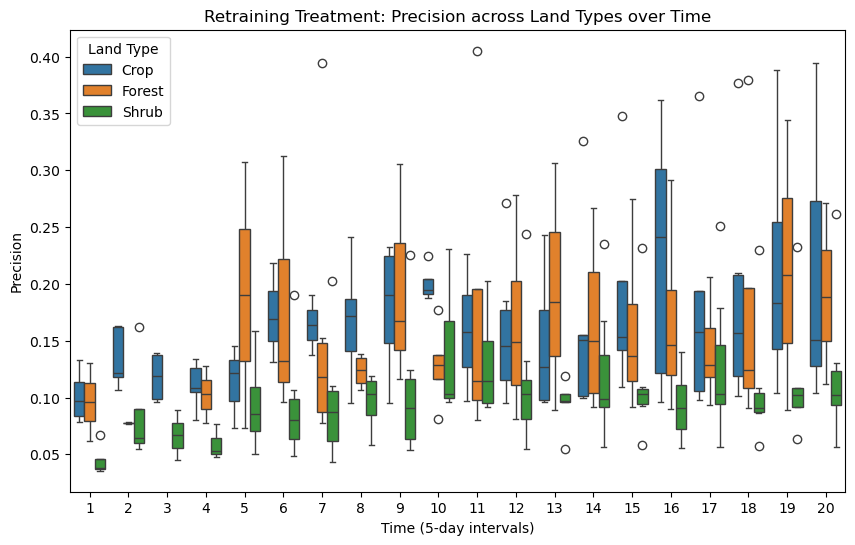

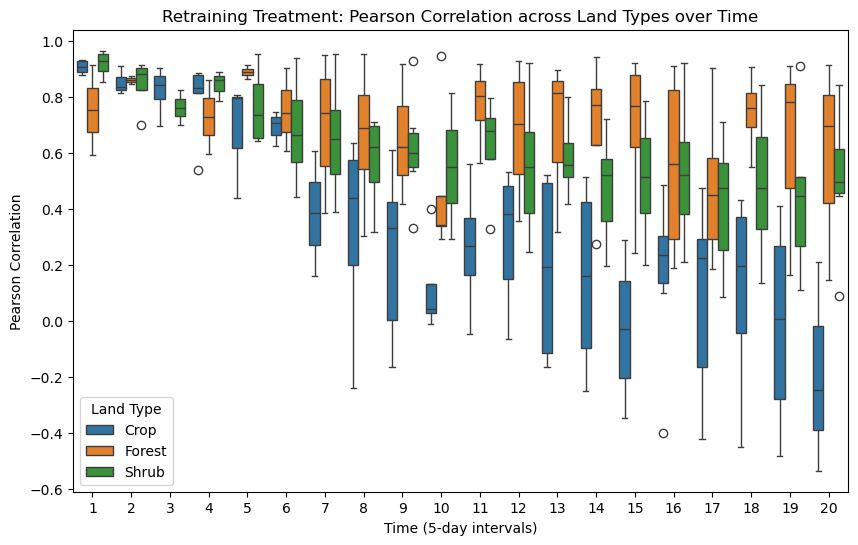

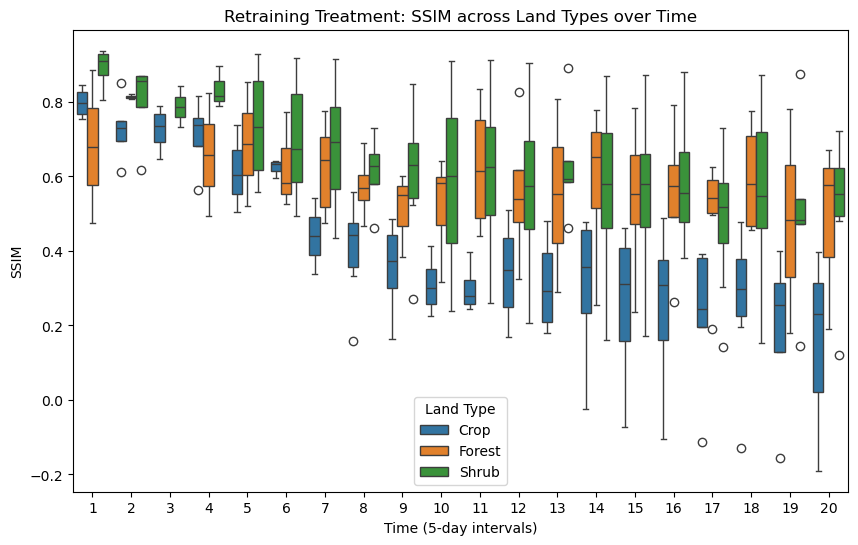

In [58]:

sites = {
    "Crop": ["29TQF",
            "30TWK",
            "30UYU",
            "31TBF", 
            "31UFP", 
            "32UNC", 
            "33UWT", 
            "33UXP", 
            "34TFL",
            "34SEJ"],

    "Forest": ["29TNE",
            "30TTK",
            "31TBF",
            "31UFP",
            "33UWT", 
            "33VVG",
            "33VUF", 
            "33VUG",
            "34SFF", 
            "34SEJ"],

    "Shrub": ["29SND",
            "29SPC", 
            "29TQF", 
            "30TTK",
            "30STJ", 
            "30UYV",
            "31TBF",
            "32TML", 
            "34SFF", 
            "34TCL"]
}
root = "E:/DZ/retraining"
predictions = "retrained_predictions"
crop_input, forest_input, shrub_input = gather_inputs(root, predictions, sites)
crop_reference, forest_reference, shrub_reference = gather_references(root, sites)

crop_datasets = gather_metrics(crop_input, crop_reference)
forest_datasets = gather_metrics(forest_input, forest_reference)
shrub_datasets = gather_metrics(shrub_input, shrub_reference)
metrics = ["Uncertainty", "Accuracy", "Precision", "Pearson Correlation", "SSIM"]
for i in range(len(metrics)):
    plt.figure(figsize=(10,6))
    plot_metric(crop_datasets[metrics[i]], forest_datasets[metrics[i]], shrub_datasets[metrics[i]], metrics[i])
    plt.title(f"Retraining Treatment: {metrics[i]} across Land Types over Time")
    plt.xlabel("Time (5-day intervals)")
    plt.ylabel(metrics[i])
    plt.legend(title="Land Type")
    plt.show()  

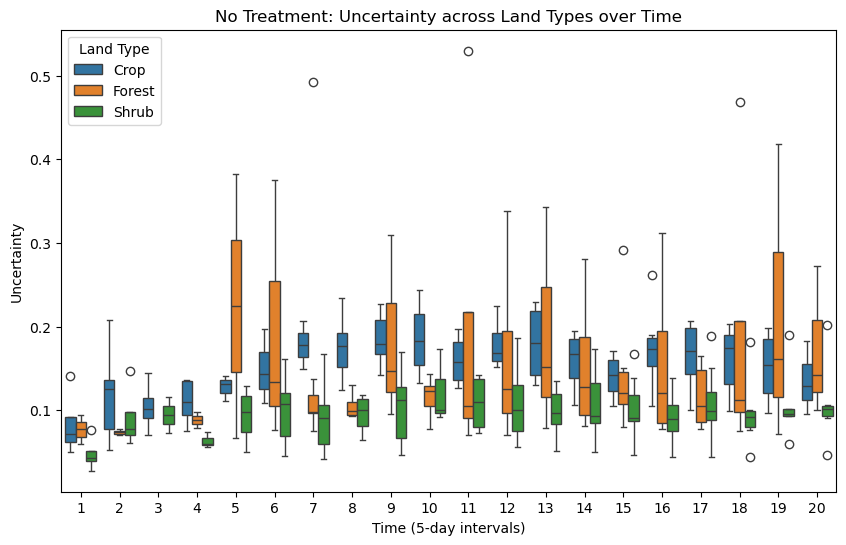

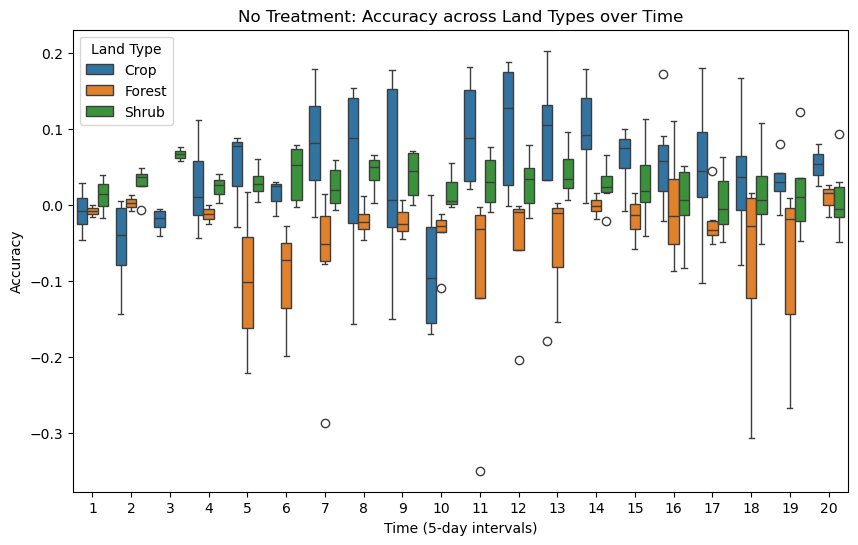

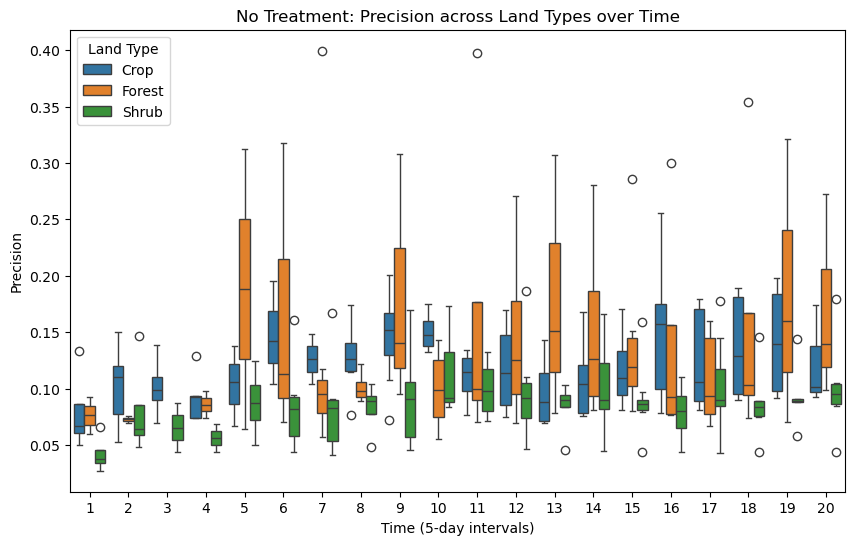

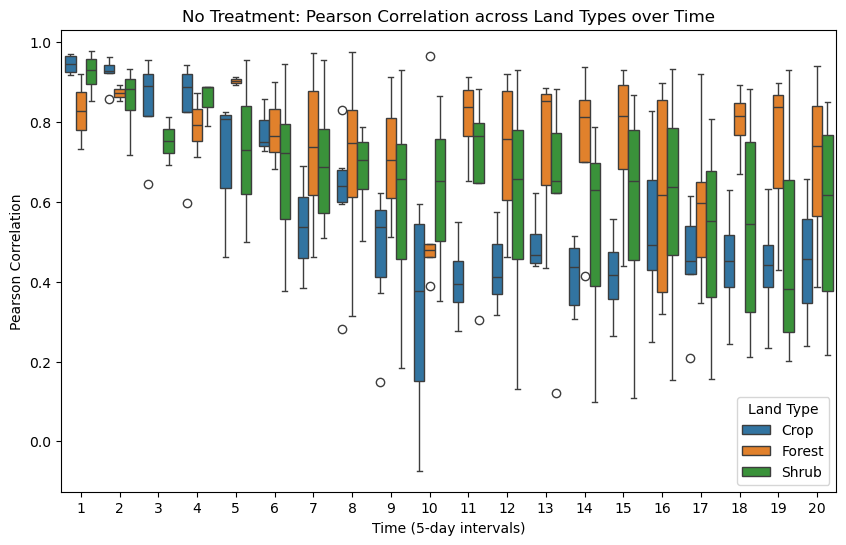

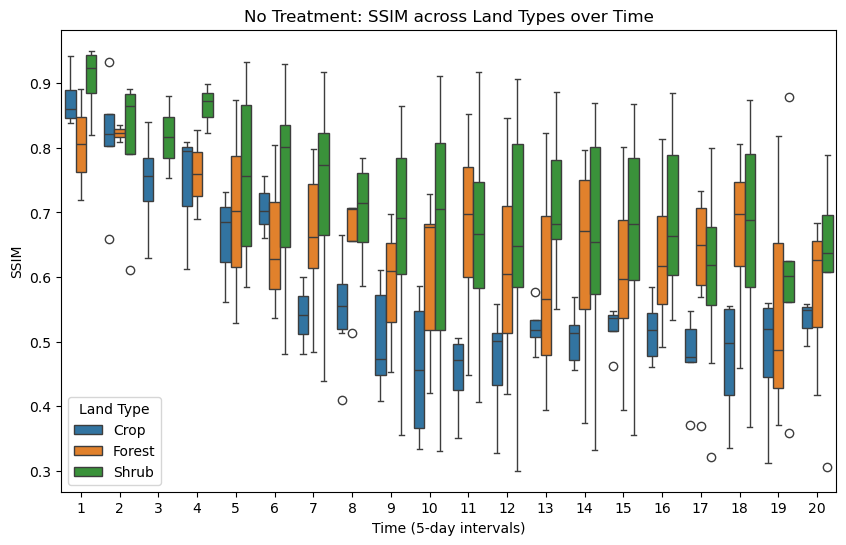

In [57]:

sites = {
    "Crop": ["29TQF",
            "30TWK",
            "30UYU",
            "31TBF", 
            "31UFP", 
            "32UNC", 
            "33UWT", 
            "33UXP", 
            "34TFL",
            "34SEJ"],

    "Forest": ["29TNE",
            "30TTK",
            "31TBF",
            "31UFP",
            "33UWT", 
            "33VVG",
            "33VUF", 
            "33VUG",
            "34SFF", 
            "34SEJ"],

    "Shrub": ["29SND",
            "29SPC", 
            "29TQF", 
            "30TTK",
            "30STJ", 
            "30UYV",
            "31TBF",
            "32TML", 
            "34SFF", 
            "34TCL"]
}
root = "E:/DZ/retraining"
predictions = "original_predictions"
crop_input, forest_input, shrub_input = gather_inputs(root, predictions, sites)
crop_reference, forest_reference, shrub_reference = gather_references(root, sites)

crop_datasets = gather_metrics(crop_input, crop_reference)
forest_datasets = gather_metrics(forest_input, forest_reference)
shrub_datasets = gather_metrics(shrub_input, shrub_reference)
metrics = ["Uncertainty", "Accuracy", "Precision", "Pearson Correlation", "SSIM"]
for i in range(len(metrics)):
    plt.figure(figsize=(10,6))
    plot_metric(crop_datasets[metrics[i]], forest_datasets[metrics[i]], shrub_datasets[metrics[i]], metrics[i])
    plt.title(f"No Treatment: {metrics[i]} across Land Types over Time")
    plt.xlabel("Time (5-day intervals)")
    plt.ylabel(metrics[i])
    plt.legend(title="Land Type")
    plt.show()  

Offset

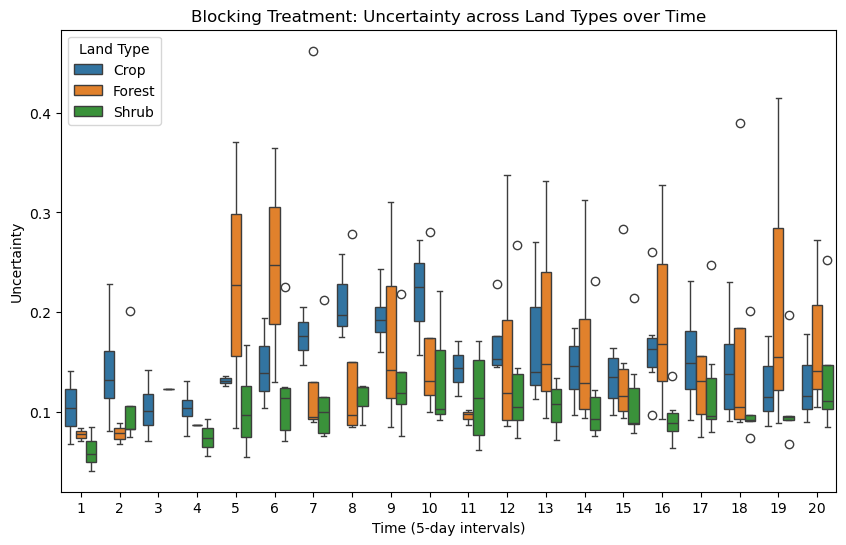

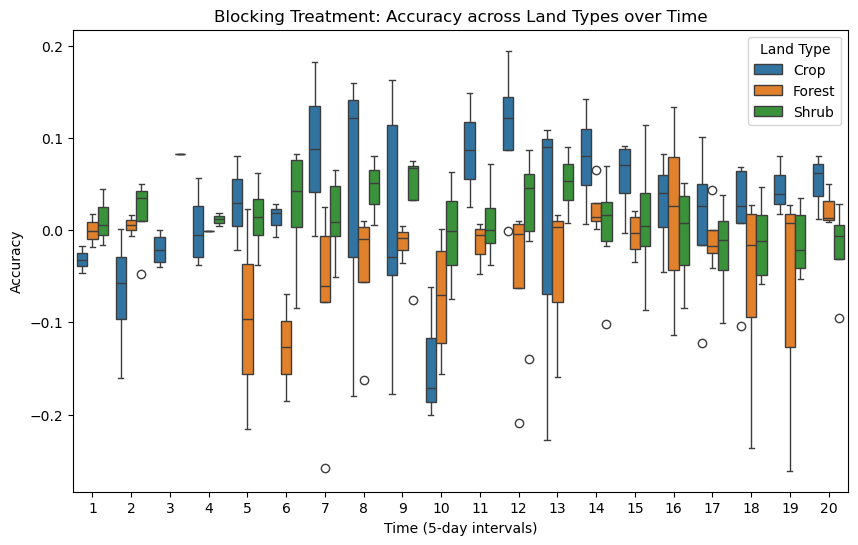

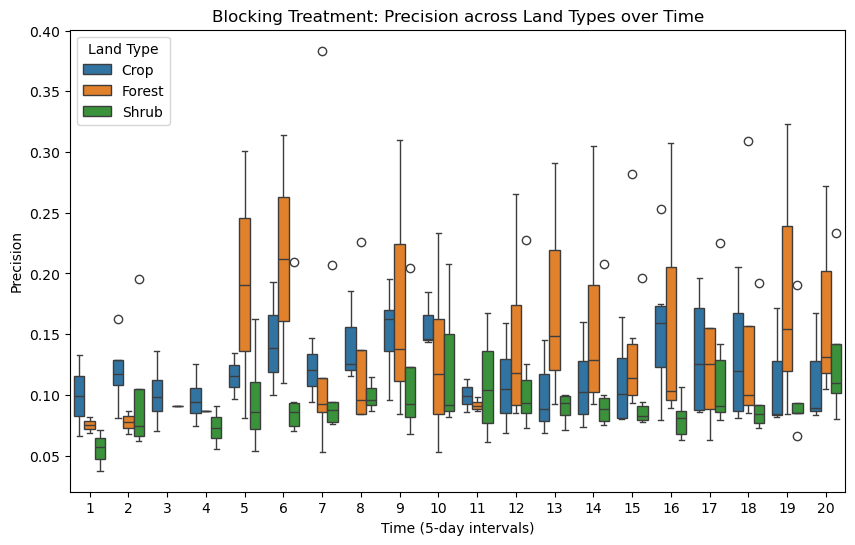

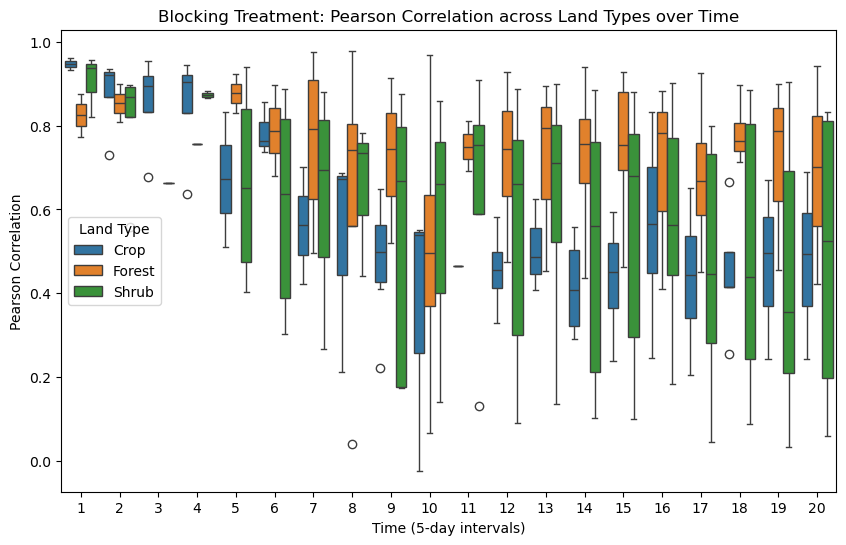

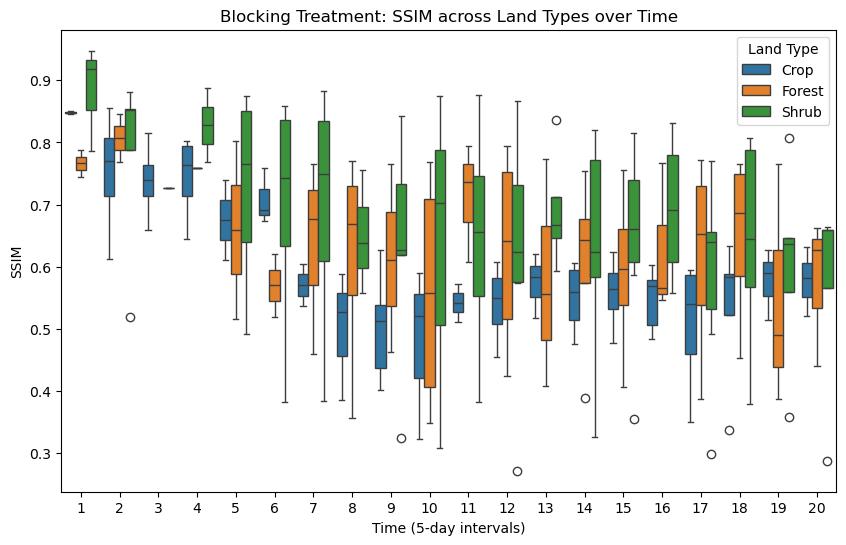

In [55]:

sites = {
    "Crop": ["29TQF",
            "30TWK",
            "30UYU",
            # "31TBF", 
            "31UFP", 
            "32UNC", 
            "33UWT", 
            "33UXP", 
            "34TFL",
            "34SEJ"],

    "Forest": ["29TNE",
            "30TTK",
            "31TBF",
            "31UFP",
            "33UWT", 
            "33VVG",
            "33VUF", 
            # "33VUG",
            "34SFF", 
            "34SEJ"],

    "Shrub": ["29SND",
            "29SPC", 
            "29TQF", 
            # "30TTK",
            "30STJ", 
            "30UYV",
            "31TBF",
            "32TML", 
            "34SFF", 
            "34TCL"]
}
root = "E:/DZ/offset"
crop_input, forest_input, shrub_input = gather_offset_inputs(root, "offset", sites)
crop_reference, forest_reference, shrub_reference = gather_references(root, sites)

crop_datasets = gather_metrics(crop_input, crop_reference)
forest_datasets = gather_metrics(forest_input, forest_reference)
shrub_datasets = gather_metrics(shrub_input, shrub_reference)
metrics = ["Uncertainty", "Accuracy", "Precision", "Pearson Correlation", "SSIM"]
for i in range(len(metrics)):
    plt.figure(figsize=(10,6))
    plot_metric(crop_datasets[metrics[i]], forest_datasets[metrics[i]], shrub_datasets[metrics[i]], metrics[i])
    plt.title(f"Blocking Treatment: {metrics[i]} across Land Types over Time")
    plt.xlabel("Time (5-day intervals)")
    plt.ylabel(metrics[i])
    plt.legend(title="Land Type")
    plt.show()  

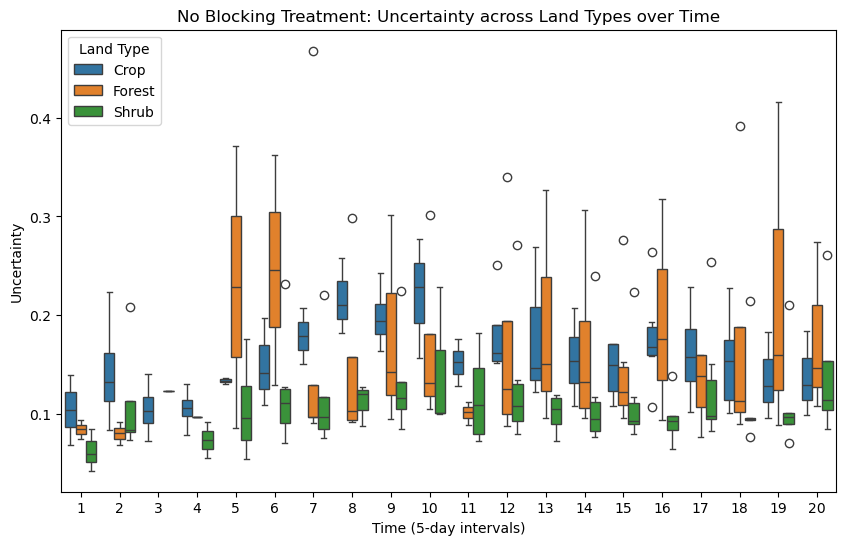

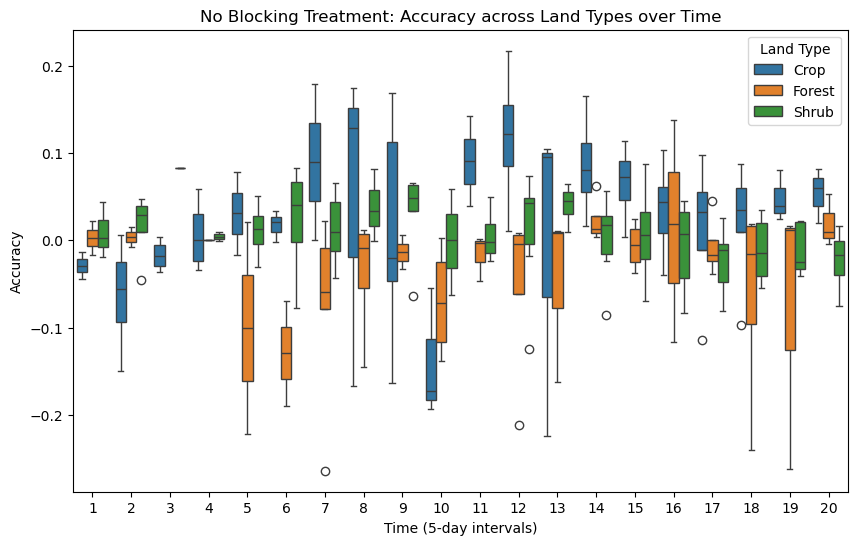

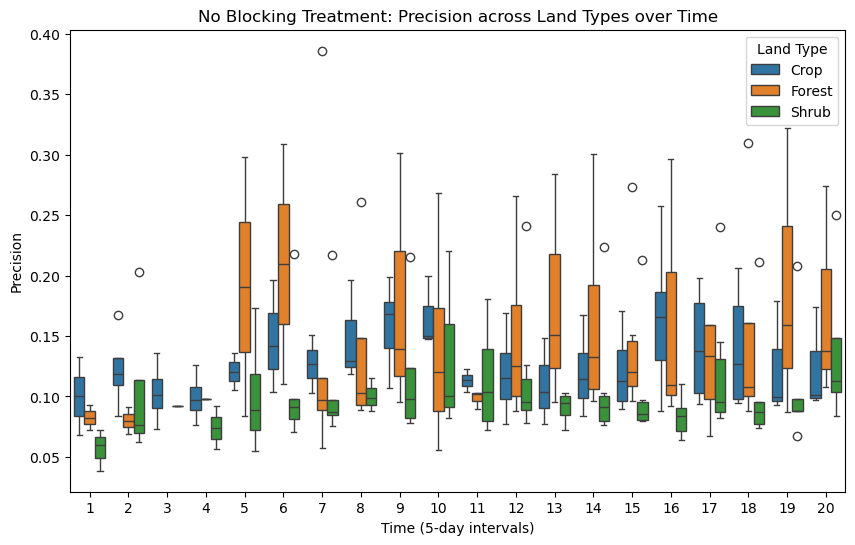

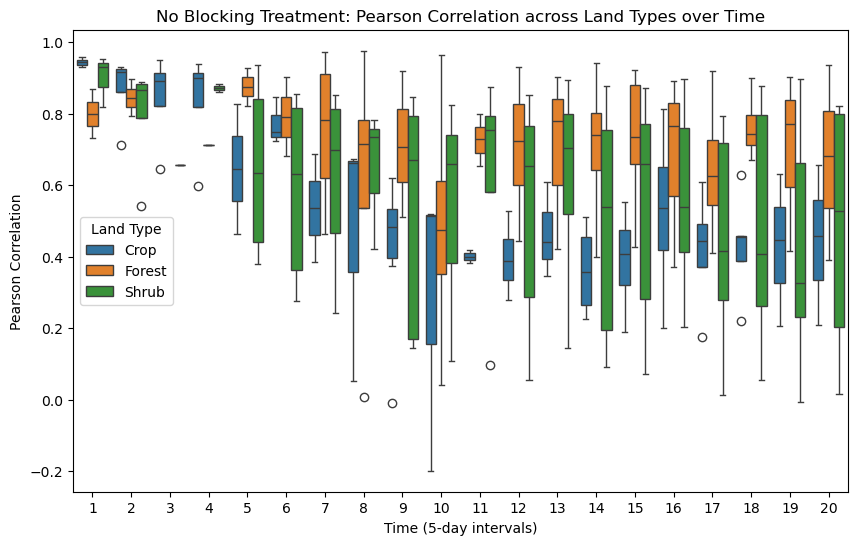

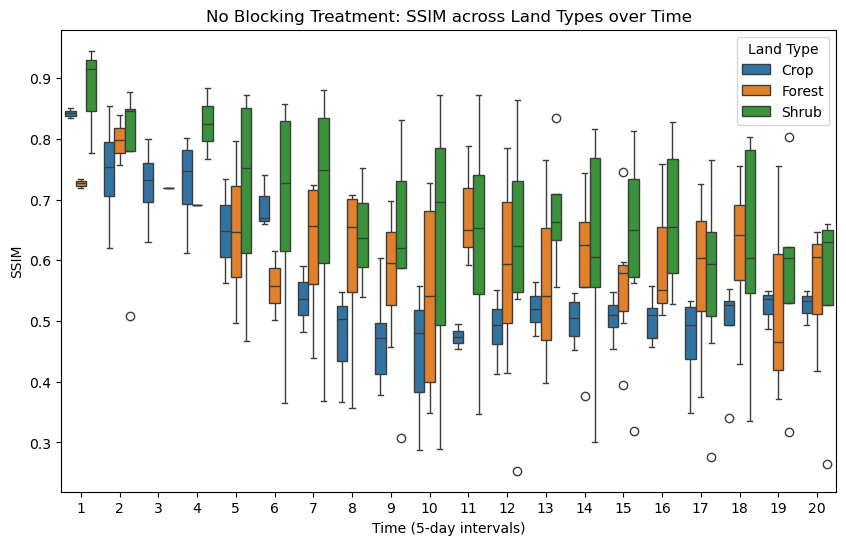

In [56]:
sites = {
    "Crop": ["29TQF",
            "30TWK",
            "30UYU",
            # "31TBF", 
            "31UFP", 
            "32UNC", 
            "33UWT", 
            "33UXP", 
            "34TFL",
            "34SEJ"],

    "Forest": ["29TNE",
            "30TTK",
            "31TBF",
            "31UFP",
            "33UWT", 
            "33VVG",
            "33VUF", 
            # "33VUG",
            "34SFF", 
            "34SEJ"],

    "Shrub": ["29SND",
            "29SPC", 
            "29TQF", 
            # "30TTK",
            "30STJ", 
            "30UYV",
            "31TBF",
            "32TML", 
            "34SFF", 
            "34TCL"]
}
root = "E:/DZ/offset"
crop_input, forest_input, shrub_input = gather_offset_inputs(root, "", sites)
crop_reference, forest_reference, shrub_reference = gather_references(root, sites)

crop_datasets = gather_metrics(crop_input, crop_reference)
forest_datasets = gather_metrics(forest_input, forest_reference)
shrub_datasets = gather_metrics(shrub_input, shrub_reference)
metrics = ["Uncertainty", "Accuracy", "Precision", "Pearson Correlation", "SSIM"]
for i in range(len(metrics)):
    plt.figure(figsize=(10,6))
    plot_metric(crop_datasets[metrics[i]], forest_datasets[metrics[i]], shrub_datasets[metrics[i]], metrics[i])
    plt.title(f"No Blocking Treatment: {metrics[i]} across Land Types over Time")
    plt.xlabel("Time (5-day intervals)")
    plt.ylabel(metrics[i])
    plt.legend(title="Land Type")
    plt.show()  

60.037026404487136 12.050420725337851


<xarray.Dataset> Size: 119MB
Dimensions:              (time: 150, lon: 128, lat: 128)
Coordinates:
  * time                 (time) datetime64[ns] 1kB 2021-03-09 ... 2021-08-05
  * lon                  (lon) float64 1kB 12.03 12.03 12.03 ... 12.07 12.07
  * lat                  (lat) float64 1kB 60.05 60.05 60.05 ... 60.03 60.03
    sentinel:product_id  float64 8B ...
    latitude_eobs        float64 8B ...
    longitude_eobs       float64 8B ...
Data variables: (12/21)
    s2_SCL               (time, lat, lon) float64 20MB ...
    s2_avail             (time) float64 1kB ...
    s2_B02               (time, lat, lon) float64 20MB ...
    s2_B03               (time, lat, lon) float64 20MB ...
    s2_B04               (time, lat, lon) float64 20MB ...
    s2_B8A               (time, lat, lon) float64 20MB ...
    ...                   ...
    eobs_rr              (time) float64 1kB ...
    eobs_tg              (time) float64 1kB ...
    eobs_tn              (time) float64 1kB ...
    eobs_tx              (time) float64 1kB ...
    s2_dlmask            (time, lat, lon) float64 20MB ...
    eobs_fgv26           (time) float64 1kB ...
Attributes:
    dataset_name:        EarthNet2021x
    dataset_name_short:  en21x
    dataset_version:     v1.0
    description:         This is a minicube from the EarthNet2021x dataset, a...
    provided_by:         Max-Planck-Institute for Biogeochemistry

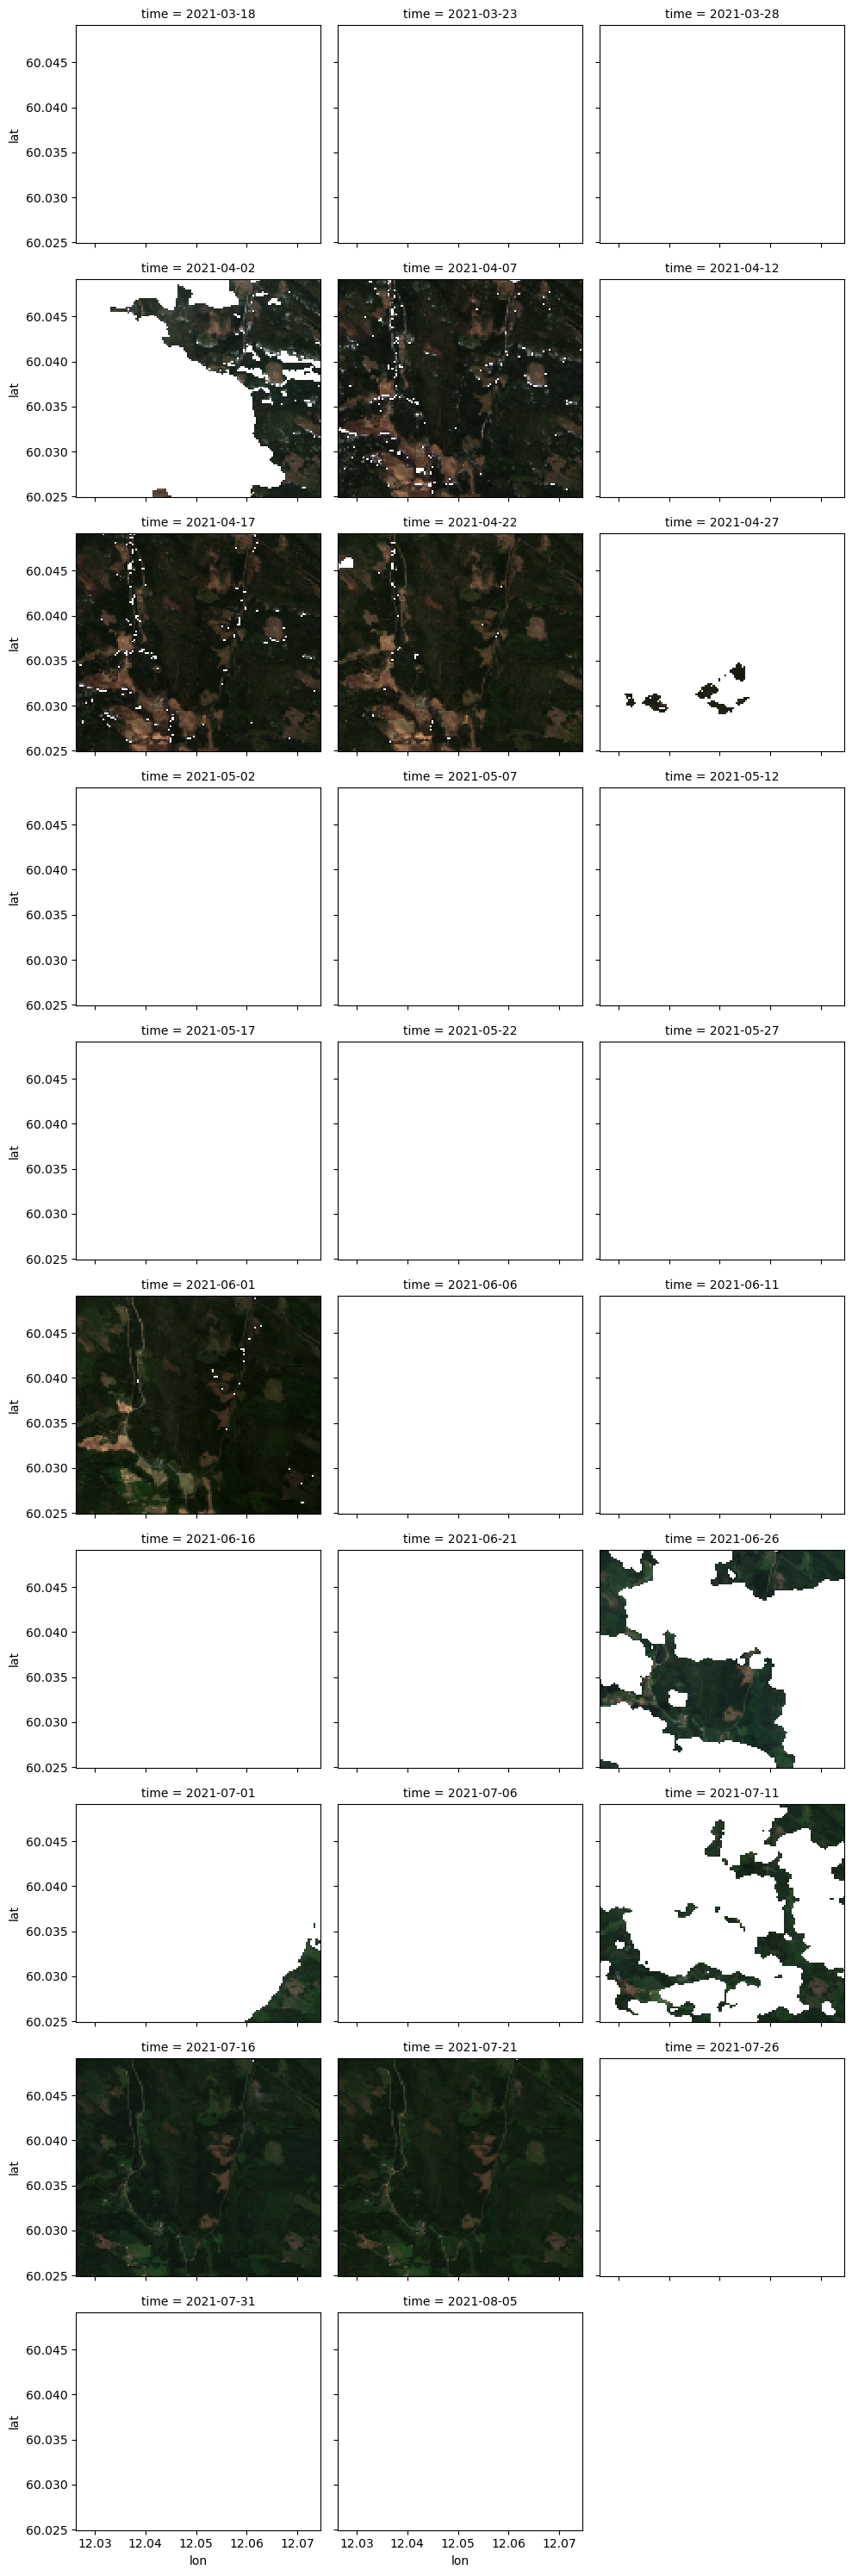

In [39]:

# xr.open_dataset(r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_0_29SND_39.29_-8.56.nc")

#Crop
# ds = xr.open_dataset(r"E:\DZ\retraining\TrainingData\crop_dominated\train\34TFL\34TFL_2017-07-14_2017-12-10_3385_3513_2105_2233_52_132_32_112_f0.00_c0.96_s0.01.nc")
# ds = xr.open_dataset(r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_227_34TFL_40.83_22.37.nc")


#Forest
# ds = xr.open_dataset(r"E:\DZ\retraining\TrainingData\forest_dominated\train\31TBF\31TBF_2017-10-09_2018-03-07_3641_3769_2233_2361_56_136_34_114_f0.93_c0.01_s0.05.nc")
# ds = xr.open_dataset(r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_61_31TBF_41.20_-0.55.nc")

# ds = xr.open_dataset(r"E:\DZ\retraining\TrainingData\forest_dominated\train\31UFP\31UFP_2018-04-04_2018-08-31_3257_3385_1465_1593_50_130_22_102_f0.97_c0.02_s0.01.nc")
# ds = xr.open_dataset(r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_87_31UFP_48.13_5.44.nc")

#Shrub
# ds = xr.open_dataset(r"E:\DZ\retraining\TrainingData\shrub_dominated\train\30UYV\30UYV_2018-04-20_2018-09-16_2745_2873_1465_1593_42_122_22_102_f0.15_c0.04_s0.81.nc")
# ds = xr.open_dataset(r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_58_30UYV_48.73_1.18.nc")

# ds = xr.open_dataset(r"E:\DZ\retraining\TrainingData\shrub_dominated\train\31TBF\31TBF_2017-12-18_2018-05-16_4793_4921_953_1081_74_154_14_94_f0.12_c0.09_s0.76.nc")
# ds = xr.open_dataset(r"E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_61_31TBF_41.20_-0.55.nc")


ds = xr.open_dataset(r"E:\DZ\retraining\Forest\33VUG\ood-t_chopped\MJJ21\minicube_183_33VUG_60.04_12.05_f0.94_c0.03_s0.02.nc")
# emc.plot_rgb(ds)
emc.plot_rgb(ds.rename({"s2_dlmask": "s2_mask"}))
# ds
latitude = np.median(ds.lat)
longitude = np.median(ds.lon)
# r"E:\DZ\retraining\TrainingData\crop_dominated\train\34TFL\34TFL_2017-07-14_2017-12-10_3385_3513_2105_2233_52_132_32_112_f0.00_c0.96_s0.01.nc"
print(latitude, longitude) #48.14 4.76
# imagery starts on 2017-07-13, date starts on 2017-07-14
ds


In [38]:
# xr.open_dataset(r"E:\DZ\retraining\Shrub\30UYV\ood-t_chopped\MJJ21\31UFP_49.10_0.16.nc")
# xr.open_dataset(r"E:\DZ\retraining\Shrub\31TBF\ood-t_chopped\MJJ21\31UFP_40.63_-0.31.nc")

# xr.open_dataset(r"E:\DZ\retraining\Forest\31TBF\ood-t_chopped\MJJ21\31TBF_40.84_-0.01.nc")
# xr.open_dataset(r"E:\DZ\retraining\Forest\31UFP\ood-t_chopped\MJJ21\31UFP_48.14_4.76.nc")

# xr.open_dataset(r"E:\DZ\retraining\Crop\34TFL\ood-t_chopped\MJJ21\minicube_34TFL_40.92_22.70.nc")

ds = xr.open_dataset(r"C:\Users\dozhang\Downloads\geom_90M\geom_90M_n55w010.tif")
ds
lat_min = ds.y.min().item()
lat_max = ds.y.max().item()
lon_min = ds.x.min().item()
lon_max = ds.x.max().item()

print(f"Lat: [{lat_min}, {lat_max}]")
print(f"Lon: [{lon_min}, {lon_max}]")
ds = xr.open_dataset(r"C:\Users\dozhang\Downloads\geom_90M\geom_90M_n55w005.tif")
ds
lat_min = ds.y.min().item()
lat_max = ds.y.max().item()
lon_min = ds.x.min().item()
lon_max = ds.x.max().item()

print(f"Lat: [{lat_min}, {lat_max}]")
print(f"Lon: [{lon_min}, {lon_max}]")


Lat: [55.000416666666666, 59.999583333333334]
Lon: [-9.999583333333334, -5.000416666666666]
Lat: [55.000416666666666, 59.999583333333334]
Lon: [-4.999583333333334, -0.0004166666666662877]
